## Exercise 2

---

**Task: write a function to shift an MNIST image 1 pixel any direction. Create 4 shifted copies per image in the training set and train a model on this.**

I'm going to create the function, and then use a loop to call it over the training set and create an augmented training set from that

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
from scipy.ndimage import interpolation

# function should shift the one dimensional array from the mnist set
# If it were necessary, it could be rewritten to scale based on the image width
# The mnist set is only 28x28 though so I'm not going to here.
def shift_mnist(image, direction=0):
    # Tuple to enforce order, the NESW values necessary to shift a 1d array
    cardinals = (-28, 1, 28, -1)
    return interpolation.shift(image, cardinals[direction], cval=0.0)

In [3]:
import numpy as np
# I want to be able to pass in the mnist set, and get back the same set but with all the extra images
# Challenge is also making sure to correctly add the labels
def augment_mnist(data, targets):
    # First, go through every image in dataset
    list_data = data.tolist()
    list_targets = targets.tolist()
    loops = len(list_data)
    for i in range(0,loops):

        for j in range(0,4):
            # each image gets shifted 4 times and deposited
            list_data.append(shift_mnist(list_data[i],j))
            # np.put(data, len(data), shift_mnist(image, i))
            # every time we add an image to the dataset, we also need to put it's label in the targets
            list_targets.append(list_targets[i])
            # np.put(targets, len(targets), targets[data.index(image)])
    return np.array(list_data), np.array(list_targets)


Now that functions have been defined, I need to do some data prep.

In [4]:
X, y = mnist.data, mnist.target

In [5]:
X.shape

(70000, 784)

In [6]:
X[0].shape

(784,)

*Using book code to render a digit. Leaving axes on to make it easier to notice the shift.*

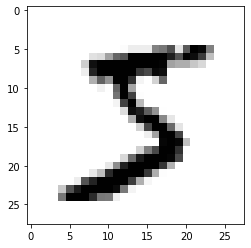

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    
some_digit = X[0]
plot_digit(some_digit)
plt.show()

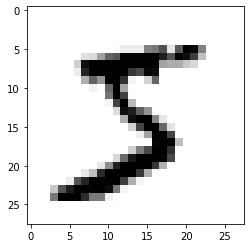

In [8]:
shifted_digit = shift_mnist(some_digit, 3)
plot_digit(shifted_digit)
plt.show()

In [9]:
# Going to split the data now, then augment it. Fingers crossed!
X_train, y_train = X[:60000], y[:60000]
X_test, y_test = X[60000:], y[60000:]

aug_X_train, aug_y_train = augment_mnist(X_train, y_train)

aug_X_train.shape

(300000, 784)

In [10]:
aug_y_train.shape

(300000,)

## Time to start working on a classifier

In [11]:
# shuffling the data now
def shuffle(X_data, y_data):
    temp_X = X_data
    temp_y = y_data
    
    shuffler = np.random.permutation(len(X_data))
    X_shuffled = temp_X[shuffler]
    y_shuffled = temp_y[shuffler]
    return X_shuffled, y_shuffled

In [12]:
shuf_train_X, shuf_train_y = shuffle(aug_X_train, aug_y_train)

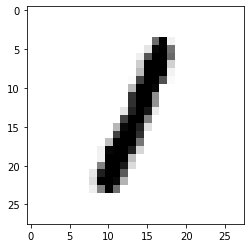

In [13]:
# peeking a bit to verify some things
first_digit = shuf_train_X[0]
plot_digit(first_digit)
plt.show()

In [14]:
shuf_train_y[0]

'1'

In [15]:
# start the KNN training process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

knn_class = KNeighborsClassifier()
knn_class.fit(shuf_train_X, shuf_train_y)

KNeighborsClassifier()

In [16]:
# Biting the time bullet, going to give a prelim cross-validation score
cross_val_score(knn_class, shuf_train_X, shuf_train_y, cv=3, scoring="accuracy")

array([0.97948, 0.97908, 0.97963])

In [17]:
param_grid = {'n_neighbors':[3,4,5,6],'weights':('uniform','distance')}

grid_search = GridSearchCV(knn_class, param_grid=param_grid)
grid_search.fit(shuf_train_X, shuf_train_y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 4, 5, 6],
                         'weights': ('uniform', 'distance')})

In [18]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [19]:
best_knn = KNeighborsClassifier(n_neighbors=4,weights='distance')
best_knn.fit(shuf_train_X, shuf_train_y)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_prediction = cross_val_predict(best_knn, shuf_train_X, shuf_train_y, cv=3)

In [28]:
from sklearn.metrics import f1_score

f1_score(shuf_train_y, y_train_prediction, average="macro")

0.9835643368510978

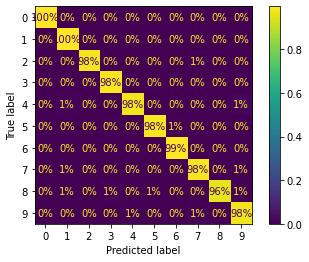

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(shuf_train_y, y_train_prediction, normalize="true", values_format=".0%")
plt.show()

# Finished! 
As you can see, our training set after augmenting and run with the best hyperparameters is over 10% better at 3's and 5's particularly. This was the training set though, so now it's time to do a good test with the test set.

In [29]:
final_predict = best_knn.predict(X_test)
results = best_knn.score(X_test, y_test)

In [30]:
results

0.9763

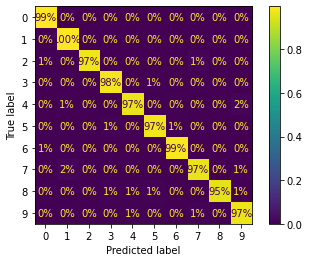

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, final_predict, normalize="true", values_format=".0%")
plt.show()

As you can see, the test set performed a little lower than the train set did. However, scores are still quite good considering this was the real test!